## Mount to drive to access images and json results from EAST text recognition

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Install pytesseract dependency

In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


## Other provided package dependency here

In [0]:
import os
import json
import cv2
import numpy as np
import pytesseract
import itertools
import re
import time
from google.colab.patches import cv2_imshow
# show available images and results below

## Bellow will show a list of available json results from EAST

In [5]:
!ls /content/drive/'My Drive'/research/image_data/results/

 2333c_rst_img.png	  'file (1)_rst_json.json'   klaus0350_rst_img.png
 2333c_rst_json.json	  'file (2)_rst_img.png'     klaus0350_rst_json.json
 2333_rst_img.png	  'file (2)_rst_json.json'   klaus0351_rst_img.png
 2333_rst_json.json	  'file (3)_rst_img.png'     klaus0351_rst_json.json
 2338c_rst_img.png	  'file (3)_rst_json.json'   klaus0352_rst_img.png
 2338c_rst_json.json	  'file (4)_rst_img.png'     klaus0352_rst_json.json
 2338_rst_img.png	  'file (4)_rst_json.json'   klaus0354_rst_img.png
 2338_rst_json.json	  'file (5)_rst_img.png'     klaus0354_rst_json.json
 chinatown_rst_img.png	  'file (5)_rst_json.json'   klaus_rst_img.png
 chinatown_rst_json.json  'file (6)_rst_img.png'     klaus_rst_json.json
'far (1)_rst_img.png'	  'file (6)_rst_json.json'   roadsign_rst_img.png
'far (1)_rst_json.json'   'file (7)_rst_img.png'     roadsign_rst_json.json
'far (2)_rst_img.png'	  'file (7)_rst_json.json'   stopsign_rst_img.png
'far (2)_rst_json.json'    file_rst_img.png	     stopsign_rst_jso

## Script to load input json

In [6]:
# provide working directory and list of image names
data_directory = '/content/drive/My Drive/research/image_data/'
image_names = [
  "klaus0348",
  "klaus0349",
  "klaus0350",
  "klaus0351",
  "klaus0352",
  "klaus0354",
  '2333',
  '2333c',
  '2338',
  '2338c',
  'far (1)',
  'far (2)',
  'far (3)',
  'far (4)',
  'file (1)',
  'file (2)',
  'file (3)',
  'file (4)',
  'file (5)',
  'file (6)',
  'file (7)',
  'file',
  'TEST',
  'web'
]

# load json inputs as raw
json_input = {}
for image_name in image_names:
  full_path = os.path.join(data_directory, 'results', image_name + '_rst_json.json')
  if not os.path.exists(full_path):
    continue
  with open(full_path) as fh:
    file_content = fh.read()
    print(image_name + " FOUND")
    json_content = json.loads(file_content)
    json_input[image_name] = json_content["text_lines"]

klaus0348 FOUND
klaus0349 FOUND
klaus0350 FOUND
klaus0351 FOUND
klaus0352 FOUND
klaus0354 FOUND
2333 FOUND
2333c FOUND
2338 FOUND
2338c FOUND
far (1) FOUND
far (2) FOUND
far (3) FOUND
far (4) FOUND
file (1) FOUND
file (2) FOUND
file (3) FOUND
file (4) FOUND
file (5) FOUND
file (6) FOUND
file (7) FOUND
file FOUND
TEST FOUND
web FOUND


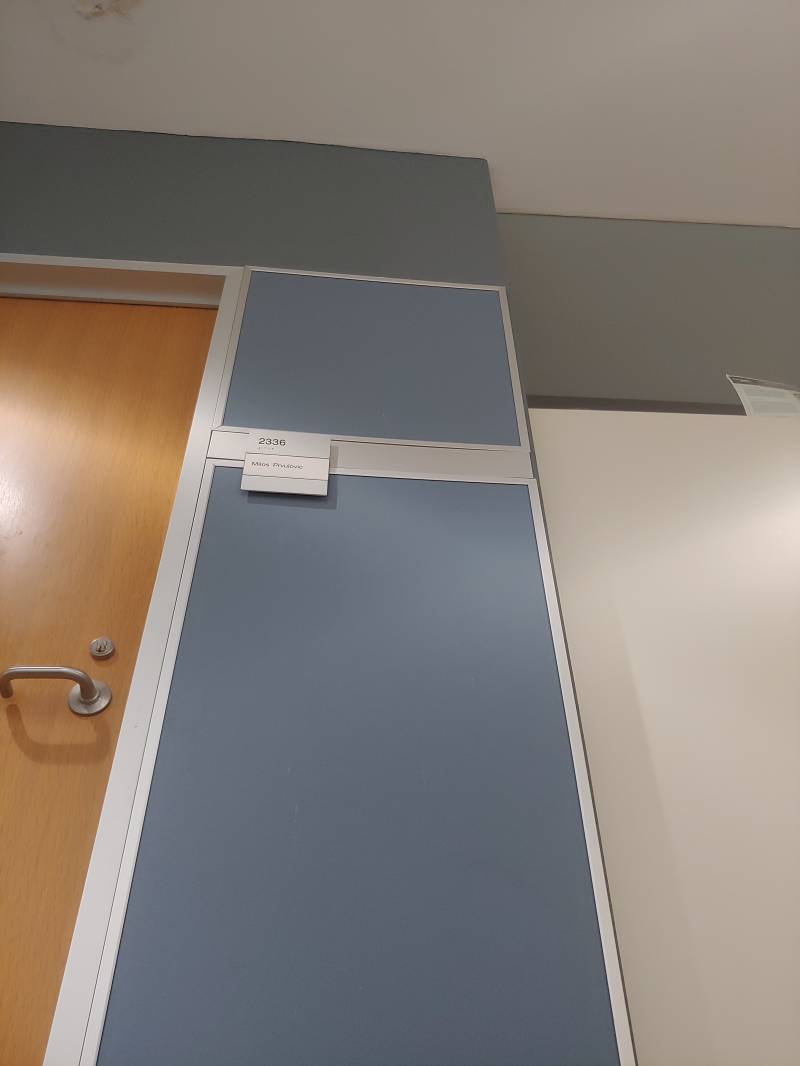

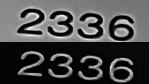

(84, 149)
{'2336': 5}
Total time: 0.93s


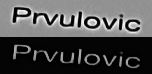

(74, 152)
{}
Total time: 0.93s


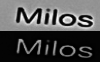

(62, 100)
{}
Total time: 0.81s


In [9]:
padding_ratio = 0.1
image_name = 'TEST' # change this to run on different images
window_max_width = 800
text_image_min_width = 100

extensions = ['.jpg', '.jpeg', '.JPG']
for extension in extensions:
  image_path = os.path.join(data_directory, 'examples', image_name + extension)
  img = cv2.imread(image_path)
  if img is not None:
    break

width = int(img.shape[1])
height = int(img.shape[0])
ratio = height / width
target_width = min(800, width)
dim = (target_width, int(target_width * ratio))
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(resized)

for data in json_input[image_name]:
  start_time = time.time()
  # get text position
  x, y = int(min(data['x0'], data['x1'], data['x2'], data['x3'])), int(min(data['y0'], data['y1'], data['y2'], data['y3']))
  max_x, max_y = int(max(data['x0'], data['x1'], data['x2'], data['x3'])), int(max(data['y0'], data['y1'], data['y2'], data['y3']))

  # apply padding_ratio
  width, height = max_x - x, max_y - y
  padding_vertical = int(height * padding_ratio)
  padding_horizontal = int(width * padding_ratio)
  x, y = int(x - padding_horizontal), int(y - padding_vertical)
  max_x, max_y = int(max_x + padding_horizontal), int(max_y + padding_vertical)

  # read and crop image using opencv
  image = img[y:max_y, x:max_x]
  width = int(image.shape[1])
  height = int(image.shape[0])
  ratio = height / width
  target_width = max(text_image_min_width, width)
  dim = (target_width, int(target_width * ratio))
  # resize image
  image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  

  # gray scale + concat
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.vconcat([image, 255 - image])

  # gamma correction
  gamma = 2.5
  lookUpTable = np.empty((1,256), np.uint8)
  for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
  image = cv2.LUT(image, lookUpTable)

  cv2_imshow(image)
  print(image.shape)
  # search optimal contrast and brightness 
  contrasts = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
  brightnesses = [0, 25, 50, 75, 100, 125, 150, 175, 200]
  composite = list(itertools.product(contrasts, brightnesses))
  composite = np.random.permutation(composite)
  predictions = {} # dict to track door tag prediction
  prediction_break = 5 # terminate prediction with success
  num_errors = 0 # counter to record errorneous prediction
  error_break = 5 # terminate prediction with error
  failures = 0 # counter to record failures
  failure_break = 100 # terminate
  impatience_break = 10
  for contrast, brightness in composite:
    curr_image = cv2.addWeighted(image, contrast, image, 0, brightness)
    # cv2_imshow(curr_image)
    # use tesseract to convert image to string
    result = pytesseract.image_to_string(curr_image, lang='eng')
    # print(contrast, brightness, result)
    regex_result = re.search('\d{4}', result)
    if regex_result:
      prediction = regex_result[0]
      if predictions.get(prediction):
        predictions[prediction] = predictions[prediction] + 1
      else:
        predictions[prediction] = 1
      if predictions[prediction] >= prediction_break or failures >= impatience_break:
        break
      failures = 0
    else:
      if result != '':
        num_errors = num_errors + 1
        if num_errors >= error_break:
          predictions = {}
          break
      else:
        failures = failures + 1
        if failures >= failure_break:
          predictions = {}
          break
  print(predictions)
  finish_time = time.time()
  print('Total time: {}s'.format(round(finish_time - start_time, 2)))